# Electricity Dataset

https://paperswithcode.com/dataset/electricity

In [52]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from darts import TimeSeries

from darts.metrics import mape, mse, rmse, mae

In [2]:
df = pd.read_csv('data/household_power_consumption.txt', sep=';', parse_dates={'ds': ['Date', 'Time']})
df = df[['ds', 'Global_active_power']]

/var/folders/fq/7hdv8yqd3ld281d0kdv2ylc80000gn/T/ipykernel_16646/4228857900.py:10: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/household_power_consumption.txt', sep=';', parse_dates={'ds': ['Date', 'Time']})
/var/folders/fq/7hdv8yqd3ld281d0kdv2ylc80000gn/T/ipykernel_16646/4228857900.py:10: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv('data/household_power_consumption.txt', sep=';', parse_dates={'ds': ['Date', 'Time']})


In [40]:
df['Global_active_power'] = pd.to_numeric(df['Global_active_power'], errors='coerce')

df.head(100)

,ds,Global_active_power
0,2006-12-16 17:24:00,4.216
1,2006-12-16 17:25:00,5.360
2,2006-12-16 17:26:00,5.374
3,2006-12-16 17:27:00,5.388
4,2006-12-16 17:28:00,3.666
...,...,...
95,2006-12-16 18:59:00,4.224
96,2006-12-16 19:00:00,4.070
97,2006-12-16 19:01:00,3.612
98,2006-12-16 19:02:00,3.458


In [4]:
# count NA values
df.isna().sum() / len(df)

ds                     0.000000
Global_active_power    0.012518
dtype: float64

In [5]:
# fill NA values with the previous value
df = df.ffill()

## Load time series data

In [6]:
TRAIN_DAYS = 7
PREDICTION_HOURS = 24

In [41]:
series = TimeSeries.from_dataframe(df, time_col='ds', value_cols='Global_active_power', fill_missing_dates=True, freq=None)
series = series.slice_n_points_before(series.end_time(), TRAIN_DAYS*24*60)

series = series.resample('30min', method='pad')

In [42]:
print(len(series))

337


<Axes: xlabel='ds'>

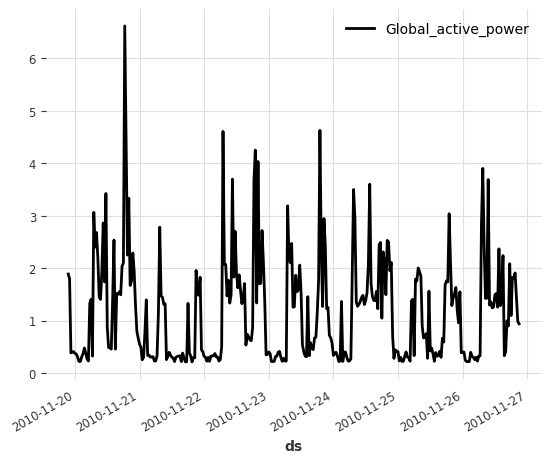

In [43]:
series.plot()

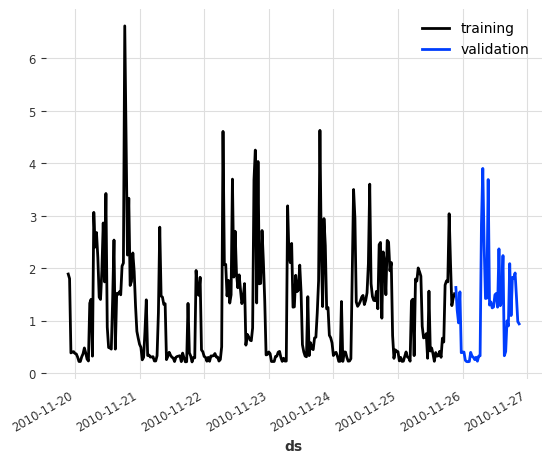

In [44]:
train, val = series.split_after(6/7)
train.plot(label="training")
val.plot(label="validation")

to_predict = len(val)

## Baseline Model

<Axes: xlabel='ds'>

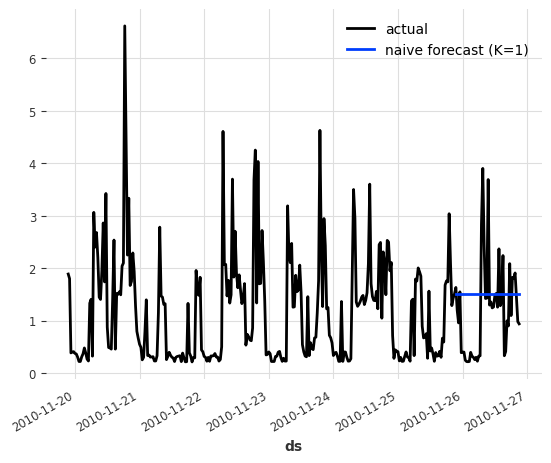

In [45]:
from darts.models import NaiveSeasonal

naive_model = NaiveSeasonal(K=1)
naive_model.fit(train)
naive_forecast = naive_model.predict(to_predict)

series.plot(label="actual")
naive_forecast.plot(label="naive forecast (K=1)")

In [46]:
from darts.models.forecasting.xgboost import XGBModel

xgb_model = XGBModel(
    lags=24,
    output_chunk_length=100,
)

xgb_model.fit(train, verbose=True)

xgb_forecast = xgb_model.predict(to_predict)


/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(


In [47]:
def plot_forecast(series, forecast, title):
    plt.figure(figsize=(25,5))
    series.plot(label="actual")
    forecast.plot(label="forecast")
    plt.title(title)
    plt.legend()
    plt.show()


In [49]:
def print_metrics(name, series, forecast):
  print(name + ' metrics:')
  print('MAPE = {:.2f}%'.format(mape(series, forecast)))
  print('RMSE = {:.2f}'.format(rmse(series, forecast)))
  print('MSE = {:.2f}'.format(mse(series, forecast)))
  print('MAE = {:.2f}'.format(mae(series, forecast)))
  print('')


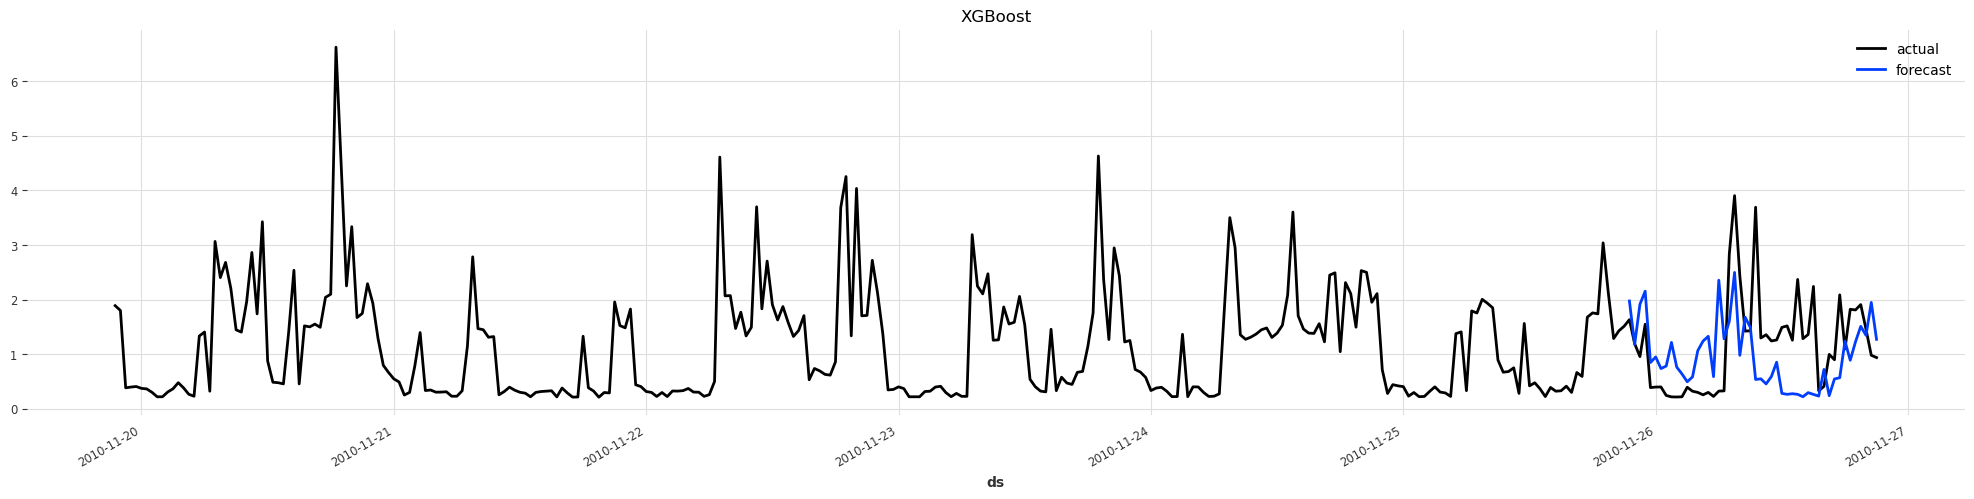

In [50]:

plot_forecast(series, xgb_forecast, "XGBoost")

In [54]:
print_metrics('XGBoost', val, xgb_forecast)
print_metrics('Naive', val, naive_forecast)

XGBoost metrics:
MAPE = 112.02%
RMSE = 1.01
MSE = 1.03
MAE = 0.81

Naive metrics:
MAPE = 164.26%
RMSE = 0.93
MSE = 0.87
MAE = 0.75



# Arima

<Axes: xlabel='ds'>

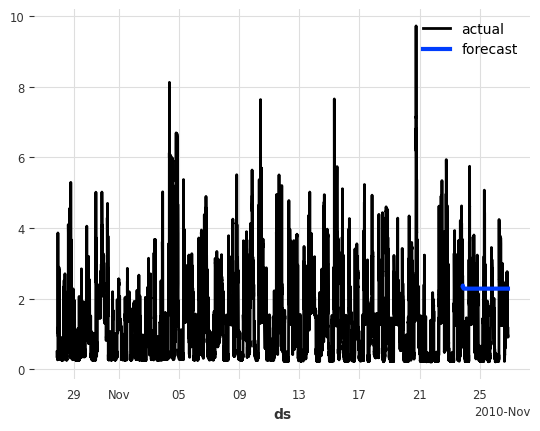

In [ ]:
# arima model
from darts.models import AutoARIMA

model = AutoARIMA(verbose=True)
model.fit(train)

prediction = model.predict(to_predict, verbose=True)

<Axes: xlabel='ds'>

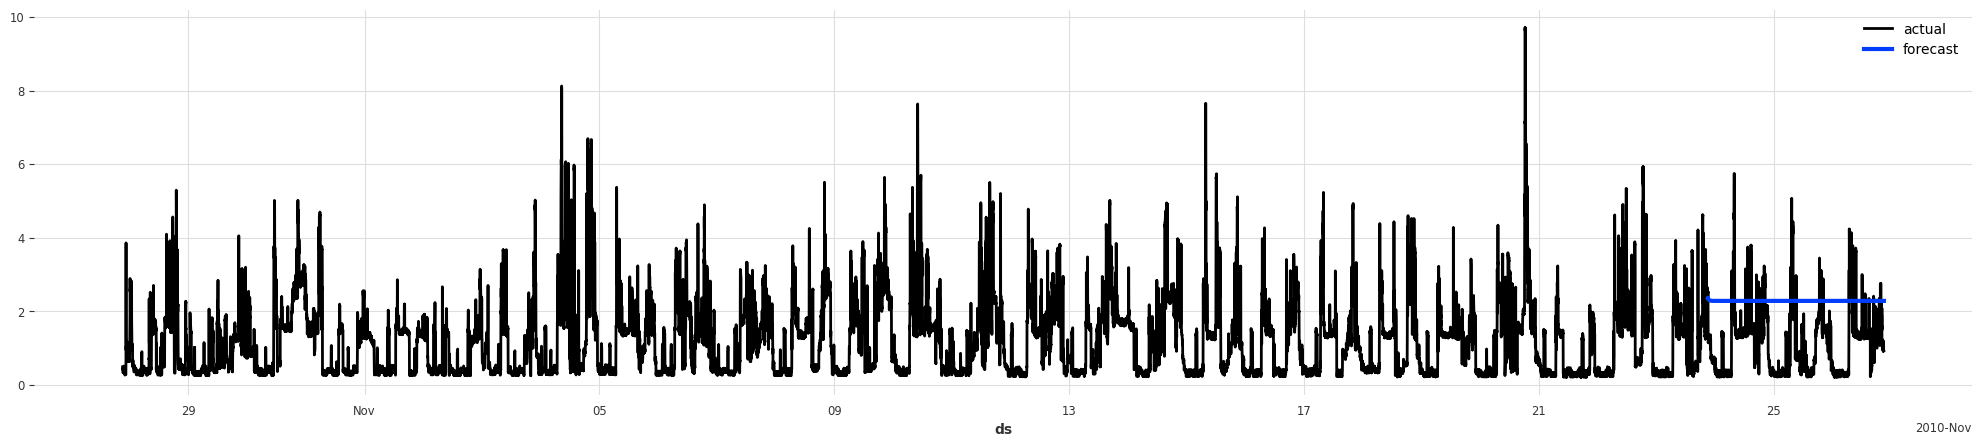

In [ ]:

plt.figure(figsize=(25,5))
series.plot(label='actual')
prediction.plot(label='forecast', lw=3)

In [ ]:
# exponential smoothing

from darts.models import ExponentialSmoothing

model_es = ExponentialSmoothing(seasonal_periods=7)
historical_fcast_es = model_es.historical_forecasts(
    series, start=0.9, verbose=True
)

series.plot(label="data")
historical_fcast_es.plot(label="backtest 3-months ahead forecast (Exp. Smoothing)")

  0%|          | 0/1009 [00:00<?, ?it/s]

KeyboardInterrupt: 